## Original version: https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/quickstart.ipynb

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Recommenders: Quickstart

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/recommenders/quickstart"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/quickstart.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/recommenders/blob/main/docs/examples/quickstart.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/recommenders/docs/examples/quickstart.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, we build a simple matrix factorization model using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) with TFRS. We can use this model to recommend movies for a given user.

### Import TFRS

First, install and import TFRS:

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.7 MB/s eta 0:00:00


In [ ]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

### Read the data

In [ ]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

In [ ]:
list(ratings.take(1).as_numpy_iterator())

[{'bucketized_user_age': 45.0,
  'movie_genres': array([7]),
  'movie_id': b'357',
  'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
  'raw_user_age': 46.0,
  'timestamp': 879024327,
  'user_gender': True,
  'user_id': b'138',
  'user_occupation_label': 4,
  'user_occupation_text': b'doctor',
  'user_rating': 4.0,
  'user_zip_code': b'53211'}]

In [ ]:
list(movies.take(1).as_numpy_iterator())

[{'movie_genres': array([4]),
  'movie_id': b'1681',
  'movie_title': b'You So Crazy (1994)'}]

In [ ]:
# Select the basic features.

# (pasangan yang memberikan rating)
# Misal pasangan (user1, movieA) itu dianggap bahwa user1 itu telah mengunjungi dan memberikan rating + positive example
# Movie yang belum pernah dikunjungi user1 misal (user1, movieX)
# contoh:
# User1 => (A, B, C)
# User2 => (A, C)
retrieval_data = ratings.map(lambda x: {
    "movie_title": x["movie_title"], # Bisa juga menggunakan movie_id
    "user_id": x["user_id"]
})


ranking_data = ratings.map(lambda x: {
    "movie_title": x["movie_title"], # Bisa juga menggunakan movie_id (input1)
    "user_id": x["user_id"], # (input 2)
    "user_rating": x["user_rating"] # Supervised Learning, sebagai label
})
# (user1, movieA) => 4 hasil prediksinya 3.8

# Untuk dibuat kamus yang akan digunakan pada proses embedding
user_ids = ratings.map(lambda x: x["user_id"])
movie_titles = movies.map(lambda x: x["movie_title"]) # Jika di atas menggunakan movie_id, disini juga harus menggunakan movie_id

Build vocabularies to convert user ids and movie titles into integer indices for embedding layers:

In [ ]:
# Berisi unique user_id
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(user_ids)

# Berisi unique movie_title
movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movie_titles)

Cara alternatif: baca user_ids, movies sebagai dataframe dengan built-in function .as_dataframe() selanjutnya filter user_id dan movie yang unique dengan built-in .unique() dilanjut dikembalikan ke format tfds dengan built-in function .from_tensor_slices().

## Retrieval

## Concept
Reference: https://developers.google.com/machine-learning/recommendation/collaborative/matrix

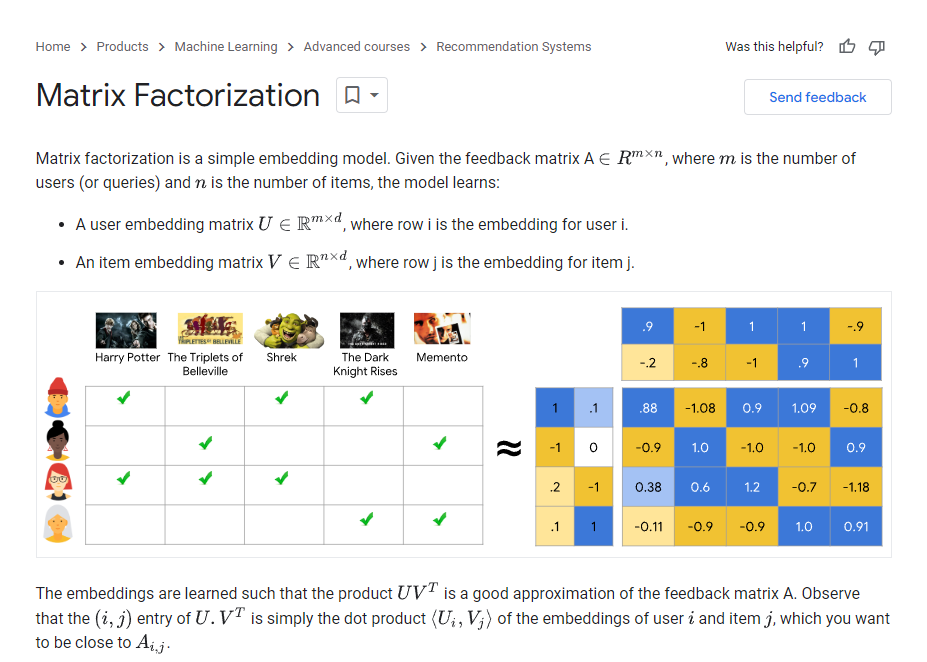

### Define a model

We can define a TFRS model by inheriting from `tfrs.Model` and implementing the `compute_loss` method:

In [ ]:
class MovieLensModelRetrieval(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)

Define the two models and the retrieval task.

In [ ]:
# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64)
])

# Define your objectives.
task_retrieval = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movie_titles.batch(128).map(movie_model)
  )
)
# The default metric is top K categorical accuracy: how often the true candidate
# is in the top K candidates for a given query. (Perlu ulik lagi)

In [ ]:
sample_user_1 = user_model.predict(["42"]) # matrix: 1 x 64
print(sample_user_1)

1/1 [==============================] - 0s 67ms/step
[[-0.04001808  0.04735063 -0.02817332 -0.01653726  0.04297541  0.02575347
   0.01109767 -0.03407957  0.02270674  0.00613096 -0.03450948 -0.03203171
  -0.03695223 -0.00309051  0.03598097  0.03246683  0.03617326  0.03427935
  -0.00034767  0.00280958  0.03960968 -0.04610721 -0.00149896  0.00038465
   0.02021703  0.02387512 -0.01745998  0.02482647 -0.03048439  0.04021168
   0.04684747 -0.02936574  0.00775294  0.03893486 -0.01140497 -0.00832929
   0.00464154 -0.04997459  0.04337371  0.01637057 -0.00171577  0.0118577
   0.04092621 -0.04118481  0.03182891 -0.02673761  0.04380232 -0.00972774
   0.00401648 -0.03680653 -0.04387441  0.01230124 -0.01163264 -0.00159205
  -0.01528467  0.01449669 -0.01370708 -0.02855188  0.04730118 -0.02135208
   0.03193862 -0.02530142  0.0226678   0.02108688]]


In [ ]:
sample_movie_1 = movie_model.predict(["You So Crazy (1994)"]) # 1 x 64
print(sample_movie_1)

1/1 [==============================] - 0s 41ms/step
[[ 0.00879285 -0.01620381 -0.03578345 -0.02680147  0.02950775 -0.01435576
   0.03354771  0.03271509  0.01103662 -0.01895541  0.02903922 -0.04210611
   0.02183257  0.01656398 -0.01149078  0.03696778 -0.04328636 -0.005899
   0.00737948 -0.03683493 -0.02573763 -0.03097776 -0.03685913 -0.0348352
   0.04849413 -0.04088169  0.0269854   0.0212121   0.04540313  0.04817141
  -0.00758718 -0.02758107 -0.03311634 -0.00402024  0.00423096 -0.03140428
  -0.0171739  -0.03208469  0.04142286  0.01424697  0.00104659 -0.01181351
   0.02726456 -0.04236888 -0.00162389  0.03014381  0.00536386 -0.03574101
  -0.02503625 -0.03932134  0.01327478  0.04463972  0.03587074 -0.02696686
  -0.04403484 -0.02064651 -0.03386543 -0.02979468 -0.04438173 -0.01115401
  -0.02918975 -0.02681394 -0.03945333 -0.02256444]]


In [ ]:
task_retrieval(sample_user_1, sample_movie_1).numpy() # returnnya bukan score hasil perkalian matrix, melainkan lossnya
# see: https://github.com/tensorflow/recommenders/blob/v0.7.3/tensorflow_recommenders/tasks/retrieval.py#L27-L211

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(1, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


0.0

In [ ]:
import numpy as np

np.matmul(np.array(sample_user_1), np.array(sample_movie_1).T)

array([[0.00548184]], dtype=float32)


### Fit and evaluate it.

Create the model, train it, and generate predictions:



In [ ]:
# Create a retrieval model.
model_retrieval = MovieLensModelRetrieval(user_model, movie_model, task_retrieval)
model_retrieval.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train for 3 epochs.
model_retrieval.fit(retrieval_data.batch(4096), epochs=3)

Epoch 1/3
25/25 [==============================] - 37s 1s/step - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0046 - factorized_top_k/top_50_categorical_accuracy: 0.0445 - factorized_top_k/top_100_categorical_accuracy: 0.1025 - loss: 33082.6286 - regularization_loss: 0.0000e+00 - total_loss: 33082.6286
Epoch 2/3
25/25 [==============================] - 35s 1s/step - factorized_top_k/top_1_categorical_accuracy: 2.3000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0144 - factorized_top_k/top_50_categorical_accuracy: 0.1051 - factorized_top_k/top_100_categorical_accuracy: 0.2095 - loss: 31008.9005 - regularization_loss: 0.0000e+00 - total_loss: 31008.9005
Epoch 3/3
25/25 [==============================] - 34s 1s/step - factorized_top_k/top_1_categorical_accuracy: 6.5000e-04 - factorized_top_k/top_5_categorical_accu

In [ ]:
# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model_retrieval.user_model)
index.index_from_dataset(
    movie_titles.batch(100).map(lambda title: (title, model_retrieval.movie_model(title))))

# Get some recommendations.
_, titles = index(np.array(["42"])) # Ini wajib dijalankan ketika mau menyimpan (warm up, supaya)
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")

Top 3 recommendations for user 42: [b'Rent-a-Kid (1995)'
 b'Far From Home: The Adventures of Yellow Dog (1995)' b'Only You (1994)']


### Save the model to deploy

In [ ]:
index.save(
    filepath="saved_model_dir/retrieval",
    overwrite=True,
    save_format="tf",
)

## Ranking

References: https://www.tensorflow.org/recommenders/examples/basic_ranking

### Define a Model

In [ ]:
# Model ini berfungsi untuk kalkulasi input embedding user dan embedding movie yang dipetakan menjadi satu input saja
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
        user_ids_vocabulary,
        tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), embedding_dimension)
    ])


    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
        movie_titles_vocabulary,
        tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), embedding_dimension)
    ])

    # Compute predictions.
    # Anggap aja seperti regresi
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1) # memprediksi rating yang diberikan oleh user

      # misal:
      # User1, movieA = 4
      # User1, movieB = 5
      # User1, movieC = 2

      # User2, movieA = 3
      # User2, movieB = 5
  ])

  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [ ]:
# Hasilnya akan variatif karna masih random belum ditraining
RankingModel()((["42"], ["One Flew Over the Cuckoo's Nest (1975)"]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00970521]], dtype=float32)>

In [ ]:
# Ini merupakan model utama, tujuannya untuk mengevaluasi performa model by metric
class MovielensModelRanking(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

### Fit and evaluate it

In [ ]:
model_ranking = MovielensModelRanking()
model_ranking.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
shuffled = ranking_data.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
# 80000:20000 = 80:20
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
model_ranking.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 5s 60ms/step - root_mean_squared_error: 2.0340 - loss: 3.8833 - regularization_loss: 0.0000e+00 - total_loss: 3.8833
Epoch 2/3
10/10 [==============================] - 0s 42ms/step - root_mean_squared_error: 1.2185 - loss: 1.4595 - regularization_loss: 0.0000e+00 - total_loss: 1.4595
Epoch 3/3
10/10 [==============================] - 0s 41ms/step - root_mean_squared_error: 1.1196 - loss: 1.2468 - regularization_loss: 0.0000e+00 - total_loss: 1.2468


In [ ]:
model_ranking.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 4s 21ms/step - root_mean_squared_error: 1.1138 - loss: 1.2450 - regularization_loss: 0.0000e+00 - total_loss: 1.2450


{'root_mean_squared_error': 1.1138359308242798,
 'loss': 1.264298439025879,
 'regularization_loss': 0,
 'total_loss': 1.264298439025879}

In [ ]:
test_ratings = {}
test_movie_titles = ["M*A*S*H (1970)", "Dances with Wolves (1990)", "Speed (1994)"] # hasil dari retrieval
for movie_title in test_movie_titles:
  test_ratings[movie_title] = model_ranking({
      "user_id": np.array(["42"]),
      "movie_title": np.array([movie_title])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
Speed (1994): [[3.6172514]]
Dances with Wolves (1990): [[3.5953078]]
M*A*S*H (1970): [[3.5192711]]


### Save the model to deploy

In [ ]:
tf.saved_model.save(model_ranking, "saved_model_dir/ranking")

## Integrasi Retrieval dan Ranking

In [ ]:
# Ada user dengan Id 42 meminta rekomandasi
# Langkah1 : melalui model retrieval kita minta 10 movie dari ribuan movie (default)
_, predict_retrieval = index(np.array(["42"]))

print("Awal=>", predict_retrieval)

# Langkah 2: ranking hasil setiap movie dalam rekomendasi
test_ratings = {}
test_movie_titles = list(predict_retrieval.numpy())[0] # hasil dari retrieval
for movie_title in test_movie_titles:
  test_ratings[movie_title] = model_ranking({
      "user_id": np.array(["42"]),
      "movie_title": np.array([movie_title])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Awal=> tf.Tensor(
[[b'Rent-a-Kid (1995)'
  b'Far From Home: The Adventures of Yellow Dog (1995)'
  b'Only You (1994)' b'House Arrest (1996)'
  b'Winnie the Pooh and the Blustery Day (1968)'
  b'Aristocats, The (1970)' b'All Dogs Go to Heaven 2 (1996)'
  b'Just Cause (1995)' b'Nell (1994)' b'Princess Caraboo (1994)']], shape=(1, 10), dtype=string)
Ratings:
b'Only You (1994)': [[3.6046987]]
b'Just Cause (1995)': [[3.584509]]
b'Rent-a-Kid (1995)': [[3.580821]]
b'Nell (1994)': [[3.5800443]]
b'House Arrest (1996)': [[3.570676]]
b'All Dogs Go to Heaven 2 (1996)': [[3.5661335]]
b'Aristocats, The (1970)': [[3.558795]]
b'Princess Caraboo (1994)': [[3.540567]]
b'Winnie the Pooh and the Blustery Day (1968)': [[3.5232482]]
b'Far From Home: The Adventures of Yellow Dog (1995)': [[3.5118697]]
